In [1]:
# this just to make sure we are using only on CPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from tqdm import tqdm_notebook

from fastmri_recon.data.fastmri_sequences import ZeroFilled2DSequence, Masked2DSequence
from fastmri_recon.helpers.nn_mri import lrelu
from fastmri_recon.helpers.reconstruction import reco_and_gt_unet_from_val_file, reco_and_gt_net_from_val_file, reco_and_gt_zfilled_from_val_file
from fastmri_recon.models.cascading import cascade_net
from fastmri_recon.models.kiki import kiki_net
from fastmri_recon.models.kiki_sep import full_kiki_net
from fastmri_recon.models.pdnet import pdnet
from fastmri_recon.models.unet import unet

Using TensorFlow backend.


In [3]:
np.random.seed(0)

In [4]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['image.cmap'] = 'gray'

In [5]:
AF = 4

In [6]:
val_path = '/media/Zaccharie/UHRes/singlecoil_val/'
val_gen_zero = ZeroFilled2DSequence(val_path, af=AF, norm=True, mode='validation', mask_seed=0)
# val_gen_zero.filenames = val_gen_zero.filenames[:2]
val_gen_scaled = Masked2DSequence(val_path, mode='validation', af=AF, scale_factor=1e6, mask_seed=0)
# val_gen_scaled.filenames = val_gen_scaled.filenames[:2]

In [7]:
val_gen_scaled.filenames[0]

'/media/Zaccharie/UHRes/singlecoil_val/file1000000.h5'

In [8]:
kspace = val_gen_scaled[0][0][0]

<IPython.core.display.Javascript object>


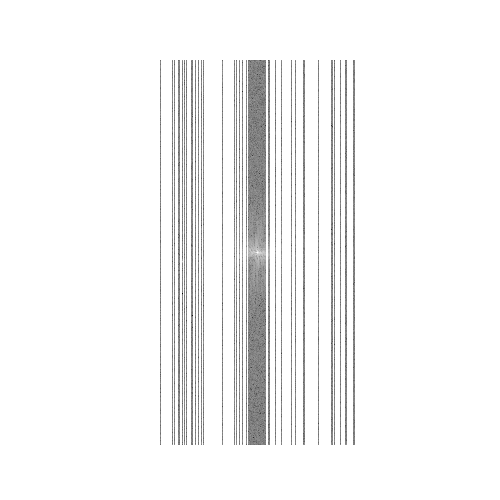

(-0.5, 367.5, 639.5, -0.5)

In [12]:
plt.figure()
plt.imshow(np.log(np.abs(np.squeeze(kspace[15]))))
plt.axis('off')

In [8]:
all_net_params = [
    {
        'name': 'unet',
        'init_function': unet,
        'run_params': {
            'n_layers': 4,
            'pool': 'max',
            "layers_n_channels": [16, 32, 64, 128],
            'layers_n_non_lins': 2,
            'input_size': (320, 320, 1),
        },
        'val_gen': val_gen_zero,
        'run_id': 'unet_af4_1569210349',
        'reco_function': reco_and_gt_unet_from_val_file,
    },
    {
        'name': 'pdnet',
        'init_function': pdnet,
        'run_params': {
            'n_primal': 5,
            'n_dual': 5,
            'n_iter': 10,
            'n_filters': 32,
        },
        'val_gen': val_gen_scaled,
        'run_id': 'pdnet_af4_1568384763',
        'reco_function': reco_and_gt_net_from_val_file,
    },
    {
        'name': 'cascadenet',
        'init_function': cascade_net,
        'run_params': {
            'n_cascade': 5,
            'n_convs': 5,
            'n_filters': 48,
            'noiseless': True,
        },
        'val_gen': val_gen_scaled,
        'run_id': 'cascadenet_af4_1568926824',
        'reco_function': reco_and_gt_net_from_val_file,
    },
#     {
#         'name': 'kikinet',
#         'init_function': kiki_net,
#         'run_params': {
#             'n_cascade': 2,
#             'n_convs': 25,
#             'n_filters': 32,
#             'noiseless': True,
#         },
#         'val_gen': val_gen_scaled,
#         'run_id': 'kikinet_af4_1568724379',
#         'reco_function': reco_and_gt_net_from_val_file,
#     },
#     {
#         'name': 'kikinet-sep-8',
#         'init_function': full_kiki_net,
#         'run_params': {
#             'n_convs': 8,
#             'n_filters': 48,
#             'noiseless': True,
#             'activation': lrelu,
#         },
#         'val_gen': val_gen_scaled,
#         'run_id': 'kikinet_sep_I2_af4_1569964596',
#         'reco_function': reco_and_gt_net_from_val_file,
#         'epoch': 50,
#     },
    {
        'name': 'kikinet-sep-16',
        'init_function': full_kiki_net,
        'run_params': {
            'n_convs': 16,
            'n_filters': 48,
            'noiseless': True,
            'activation': lrelu,
        },
        'val_gen': val_gen_scaled,
        'run_id': 'kikinet_sep_I2_af4_1570049560',
        'reco_function': reco_and_gt_net_from_val_file,
        'epoch': 50,
    },
]

In [9]:
image_index = 18
slice_index = 15
def unpack_model(init_function=None, run_params=None, run_id=None, epoch=300, **dummy_kwargs):
    model = init_function(**run_params)
    chkpt_path = f'../checkpoints/{run_id}-{epoch}.hdf5'
    model.load_weights(chkpt_path)
    return model

def save_figure(im_recos, img_batch, name):
    im_reco = im_recos[slice_index]
    im_gt = img_batch[slice_index]
    im_res = np.abs(im_gt - im_reco)
    fig, ax = plt.subplots(1, frameon=False)
    ax.imshow(np.abs(np.squeeze(im_reco)), aspect='auto')
    ax.axis('off')
    fig.savefig(f'figures/{name}_recon_af{AF}.png')
    fig, ax = plt.subplots(1, frameon=False)
    ax.imshow(np.abs(np.squeeze(im_res)), aspect='auto')
    ax.axis('off')
    fig.savefig(f'figures/{name}_residu_af{AF}.png')
    

def save_figure_for_params(reco_function=None, val_gen=None, name=None, **net_params):
    model = unpack_model(**net_params)
    im_recos, img_batch = reco_function(*val_gen[image_index], model)
    if val_gen == val_gen_scaled:
        im_recos /= 1e6
        img_batch /= 1e6
    save_figure(im_recos, img_batch, name)
    
    
def save_figure_zfilled():  
    im_recos, img_batch = reco_and_gt_zfilled_from_val_file(*val_gen_scaled[image_index])
    im_recos /= 1e6
    img_batch /= 1e6
    save_figure(im_recos, img_batch, 'zfilled')

W1015 17:51:06.438265 140035742562048 deprecation_wrapper.py:119] From /volatile/home/Zaccharie/workspace/keras/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1015 17:51:13.790693 140035742562048 deprecation_wrapper.py:119] From /volatile/home/Zaccharie/workspace/keras/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



<IPython.core.display.Javascript object>


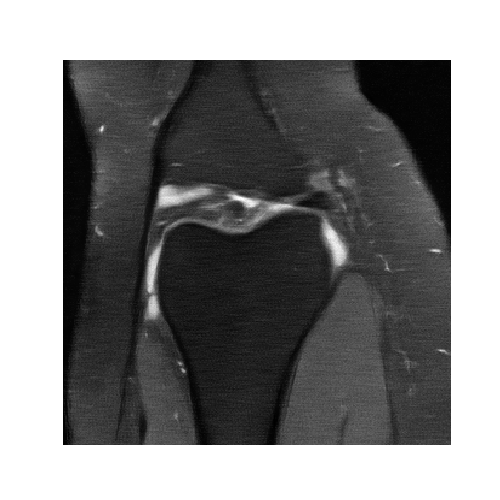

<IPython.core.display.Javascript object>


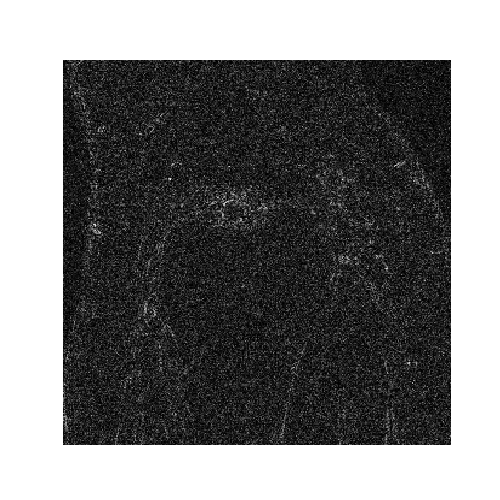

W1015 17:51:16.315538 140035742562048 deprecation.py:323] From /volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/fastmri_recon/helpers/nn_mri.py:92: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


<IPython.core.display.Javascript object>


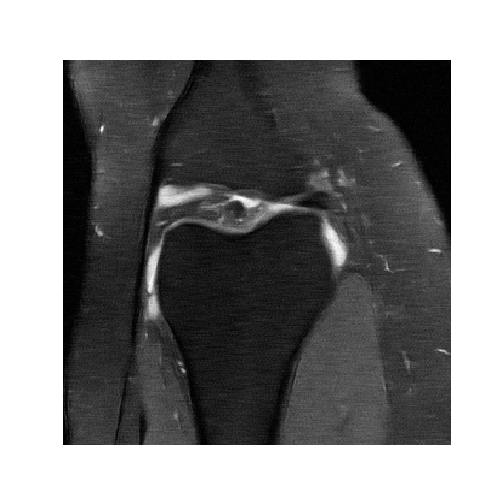

<IPython.core.display.Javascript object>


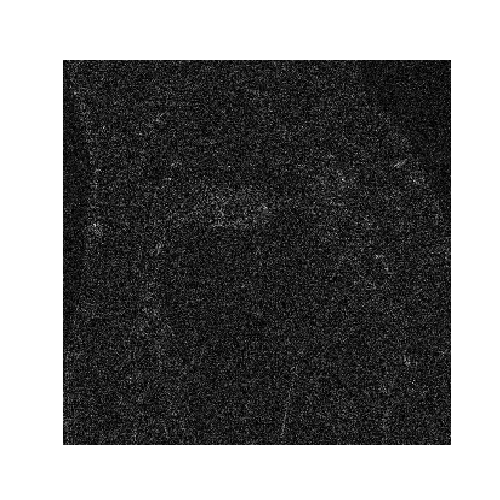

<IPython.core.display.Javascript object>


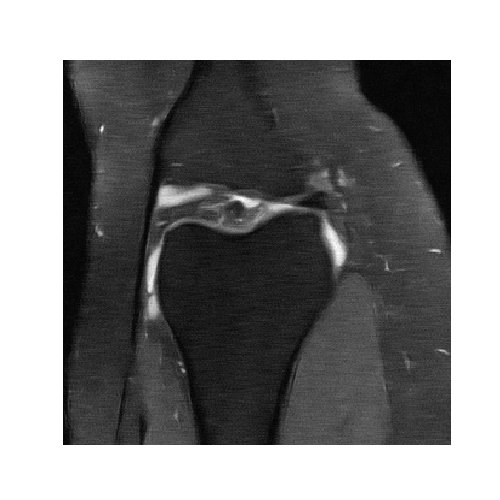

<IPython.core.display.Javascript object>


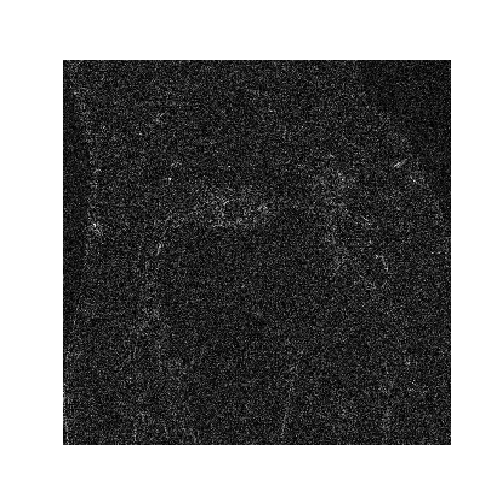

<IPython.core.display.Javascript object>


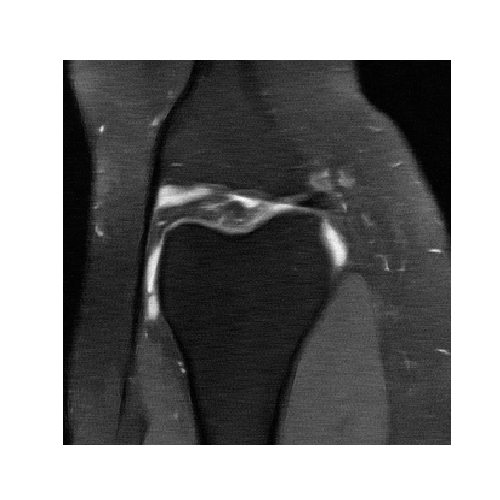

<IPython.core.display.Javascript object>


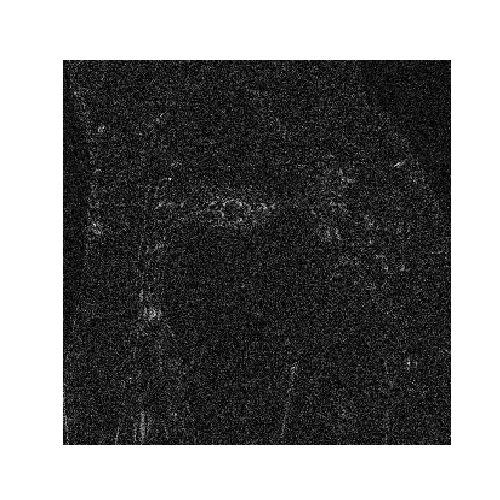

<IPython.core.display.Javascript object>


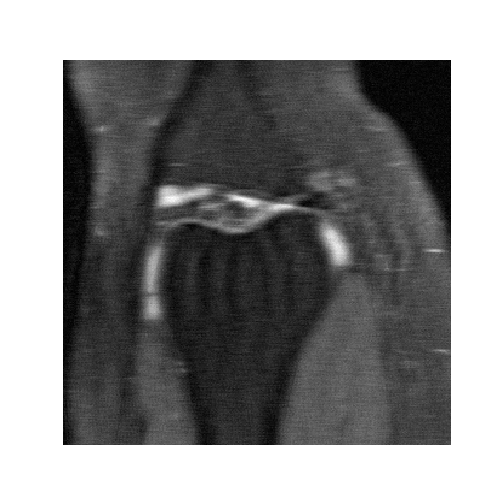

<IPython.core.display.Javascript object>


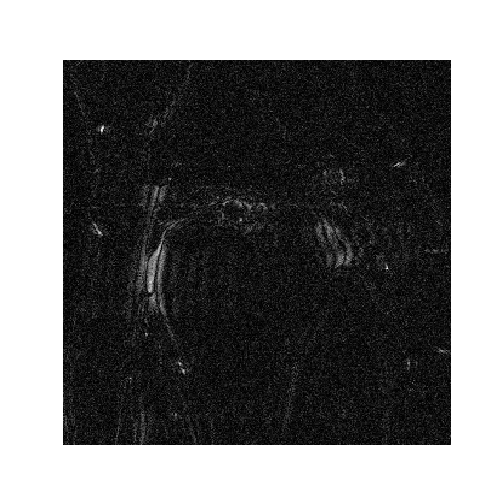

CPU times: user 34.6 s, sys: 6.89 s, total: 41.5 s
Wall time: 42.1 s


In [10]:
%%time
for net_params in all_net_params:
    save_figure_for_params(**net_params)
    
save_figure_zfilled()

<IPython.core.display.Javascript object>


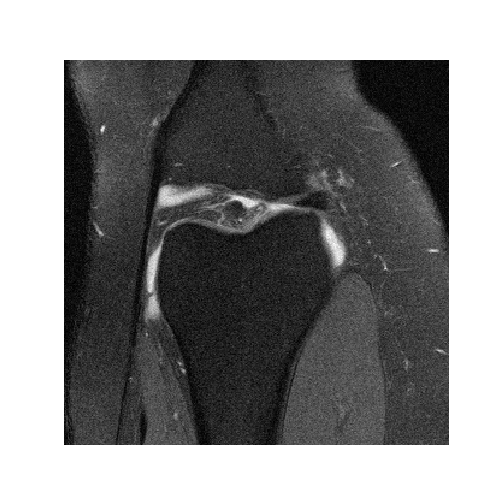

In [11]:
_, img_batch = val_gen_scaled[image_index]
img_batch /= 1e6
im_gt = img_batch[slice_index]
fig, ax = plt.subplots(1)
ax.imshow(np.abs(np.squeeze(im_gt)))
ax.axis('off')
fig.savefig(f'figures/image_gt.png')